$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge make$ $\hspace{0.1cm}$ $\Huge a$ $\hspace{0.1cm}$ $\Huge CMB$ $\hspace{0.1cm}$ $\Huge map$ $\hspace{0.1cm}$ $\Huge :$ 

# Modules : 

In [9]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt 
from matplotlib import rc
rc('text', usetex=True)
from astropy.io import fits
import numpy as np
from astropy import constants as cst
from astropy.cosmology import FlatLambdaCDM
import pysm as pysm
import ccatp_sky_model as sky

In [10]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value

In [11]:
data_path = "/vol/arc3/data1/sz/CCATp_sky_model/templates/"

# Function : 

In [12]:
def simulate_cmb(freq, cl_file = None, lensed = True, nside_out = 4096, lmax = None, beam_FWHM = None,
                 template = "SO", unit = "cmb"): 
         
    """
    Function that computes a CMB map from a power spectrum.
    Parameters
    ----------
    freq: float or float array
        Frequency of the output map in Hz.
    cl_file : str or array 
        Name of the .dat contaning the values of the power spectrum given by CAMB.
        Or array containing the power spectrum to generate random maps in Kelvin.
    lensed : bool 
        if True select the lensed CMB map when possible. This is only possible for 'CITA' and 'Sehgal.'
    nside_out: float
        Healpix nside parameter of the output map. Must be a valid value for nside.
        Default: 4096
    lmax: float
        Maximum value of the multipolemoment at which the atmospheric power spectrum
        wil be computed. Default: 3*nside_out-1            
    beam_FWHM: bool, optional
        If set, the output will be convolved with a gaussian. The FWHM of the Gaussian
        in units of arcmin is given by the provided value. Default: None
    template: bool, optional
        Determines the all-sky foregrounds templates to be used to build the sky model.
        If 'Sehgal' is chosen, simulations by Sehgal et al. (2010) are used.
        If 'SO' is chosen, the Simons Observatory sky model provided by Colin Hill and 
        based on the simulations by Sehgal et al. (2010) is used. If 'CITA' is chosen,
        the used templates will be based on the WebSky Extragalactic CMB Mocks provided 
        by CITA. Default: 'SO'
    unit: bool, optional
        Determines the units of the output map. The available units are 'mjy' --> MJy/sr
        (specific intensity), 'cmb' --> K_CMB (thermodynamic temperature), and 
        'rj' --> K_RJ (brightness temperature). Default: 'cmb'.
        
    Returns
    -------
    float array
        Healpix allsky map contaning the CMB map at a given frequency. 
    """
                
    if cl_file is not None:
    
        #Load the datas : 
        data = np.loadtxt(cl_file)
        ell = data[:,0]
        TT = data[:,1] * 2 * np.pi / ell / (ell+1)  # Take only the first column, which is the temperature T

        #Because the monopole and dipole are not in the data of the power spectrum given by CAMB we need to add them back
        #They need to be 0 because we usually remove them no to influence our studies. 
        TT_final = np.insert(TT,[0],[0,0])

        #Compute the CMB map from the power spectrum :
        CMB = hp.sphtfunc.synfast(TT_final, nside_out, lmax = lmax)
 
    else: 

        if template != "SO" and template != "CITA" and template != "Sehgal":
            
            print("Waring: Unknown template requested! Output will be based on SO sky model")
            
            template = "SO"

        if template == 'CITA':
        
            if lensed == True:

                file_name = 'CMB/CMB_lensed_CITA_mK'

            else:

                file_name = 'CMB/CMB_unlensed_CITA_mK'
            
            CMB = hp.read_map(data_path + file_name, dtype = np.float32)/1e6     
    
        elif template == 'SO': 

            file_name = 'CMB/Sehgalsimparams_healpix_4096_KappaeffLSStoCMBfullsky_phi_SimLens_Tsynfastnopell_fast_lmax8000_nside4096_interp2.5_method1_1_lensed_map.fits'

            CMB = hp.read_map(data_path + file_name, dtype = np.float32)/1e6 		

        elif template == 'Sehgal':

            if lensed == True:

                file_name = 'CMB/030_lensedcmb_healpix.fits'

            else: 

                file_name = 'CMB/030_unlensedcmb_healpix.fits'

            CMB = hp.read_map(data_path + file_name, dtype = np.float32) * convert_units(30e9, 1e-6, mjy2cmb=True)

    #Re-bin map if necessary
    if hp.get_nside(CMB) != nside_out:
        CMB = hp.pixelfunc.ud_grade(CMB, nside_out = nside_out)

    #Smooth map if necessary
    if beam_FWHM is not None:
        print("begin smoothing")
        CMB = hp.sphtfunc.smoothing(CMB, iter = 0, lmax = lmax, fwhm = beam_FWHM/60*np.pi/180)

    #Convert units if necessary
    if unit == "mjy":
        CMB = convert_units(freq, CMB, cmb2mjy=True)
    elif unit == "cmb":
        None
    elif unit == "rj":
        CMB = convert_units(freq, CMB, cmb2rj=True)
    else:
        print("Waring: Unknown unit! Output will be in K_CMB")   

    return(CMB)

# Launch and Display :

In [14]:
CMB = simulate_cmb(freq=30e9, cl_file = None, lensed = True, nside_out = 4096, lmax = None, beam_FWHM = None,
                 template = "SO", unit = "cmb")

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


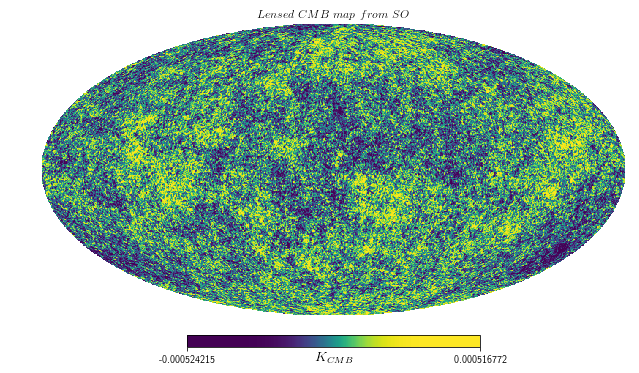

In [15]:
#Display map The White noise map: 
hp.mollview(CMB, title="$Lensed$ $CMB$ $map$ $from$ $SO$", norm='hist',unit='$K_{CMB}$')